# EDA completo (R) para `product_sales_dataset_final.csv`

Este notebook está preparado para ejecutarse en **Google Colab**. Incluye:
- Instalación de R y rpy2
- Carga del dataset
- EDA completo (dimensiones, tipos, missing)
- Gráficas representativas (ggplot2)
- Feature engineering y guardado del dataset procesado

Ejecuta las celdas en orden.

# 1) Instalación de R y rpy2

In [2]:
%%shell
sudo apt-get update -y
sudo apt-get install -y r-base

pip install rpy2

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,844 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy

# 2) Cargar la extensión rpy2


In [3]:
%load_ext rpy2.ipython

# 3) Incorporar kaggle


In [4]:
%%shell
mkdir -p ~/.kaggle
cp /content/sample_data/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [5]:
%%shell
pip install kaggle

# 4) Carga del dataset


In [6]:
%%R
system("kaggle datasets download -d yashyennewar/product-sales-dataset-2023-2024")
system("unzip -o product-sales-dataset-2023-2024.zip -d /content/")
df <- read.csv("/content/product_sales_dataset_final.csv")

# Ver un resumen rápido
cat('Dimensiones: ', dim(df)[1], 'filas y', dim(df)[2], 'columnas\n')
print(names(df))

Dimensiones:  200000 filas y 14 columnas
 [1] "Order_ID"      "Order_Date"    "Customer_Name" "City"         
 [5] "State"         "Region"        "Country"       "Category"     
 [9] "Sub_Category"  "Product_Name"  "Quantity"      "Unit_Price"   
[13] "Revenue"       "Profit"       


# 5) Información general del dataset

In [7]:
%%R
dim(df)
str(df)
head(df, 10)
summary(df)
cat('\nPorcentaje de NA por columna:\n')
print(colSums(is.na(df)) / nrow(df) * 100)

'data.frame':	200000 obs. of  14 variables:
 $ Order_ID     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Order_Date   : chr  "08-23-23" "12-20-24" "01-29-24" "11-29-24" ...
 $ Customer_Name: chr  "Bianca Brown" "Jared Edwards" "Susan Valdez" "Tina Williams" ...
 $ City         : chr  "Jackson" "Grand Rapids" "Minneapolis" "Tallahassee" ...
 $ State        : chr  "Mississippi" "Michigan" "Minnesota" "Florida" ...
 $ Region       : chr  "South" "Centre" "Centre" "South" ...
 $ Country      : chr  "United States" "United States" "United States" "United States" ...
 $ Category     : chr  "Accessories" "Accessories" "Clothing & Apparel" "Clothing & Apparel" ...
 $ Sub_Category : chr  "Small Electronics" "Small Electronics" "Sportswear" "Sportswear" ...
 $ Product_Name : chr  "Phone Case" "Charging Cable" "Nike Air Force 1" "Adidas Tracksuit" ...
 $ Quantity     : int  3 4 1 3 1 1 2 1 2 5 ...
 $ Unit_Price   : num  201 74.3 68.2 209.6 216.6 ...
 $ Revenue      : num  603 297.2 68.2 628.9 216.6 ...
 $ 

# 6) Conversión de fechas y features temporales


In [8]:
%%R
library(dplyr)

# Asegurar que lubridate esté instalado y cargado (aunque usaremos as.Date de R base)
if(!require(lubridate)) install.packages('lubridate', repos='https://cloud.r-project.org')
library(lubridate)

# Diagnóstico: Prueba con una cadena literal
test_date_str <- "08-23-23"
parsed_test_date <- as.Date(test_date_str, format = "%m-%d-%y")
cat("Cadena de fecha de prueba: ", test_date_str, "\n")
cat("Fecha de prueba parseada: ", as.character(parsed_test_date), "\n")
cat("Clase de la fecha de prueba parseada: ", class(parsed_test_date), "\n\n")

# Diagnóstico: Imprimir la clase y los primeros valores de df$Order_Date antes de la conversión
cat("Clase de df$Order_Date antes de la conversión: ", class(df$Order_Date), "\n")
cat("Primeros 5 valores de df$Order_Date antes de la conversión:\n")
print(head(df$Order_Date, 5))

# Almacenar la Order_Date original para depuración si es necesario
df$Original_Order_Date <- df$Order_Date

# Convertir explícitamente a carácter para asegurar la consistencia, luego parsear
# Este paso es crucial para forzar un vector de caracteres 'limpio', pasando por alto cualquier rareza interna de RPY2/data.frame.
df$Order_Date <- as.character(df$Order_Date) # Asegurar que es carácter
df$Order_Date <- trimws(df$Order_Date) # Eliminar cualquier espacio en blanco inicial/final

# La columna Order_Date está en formato 'MM-DD-YY'. Usando as.Date de R base para un parseo robusto.
df$Order_Date <- as.Date(df$Order_Date, format = "%m-%d-%y")

# Comprobar si se introdujeron NAs por el parseo
if(any(is.na(df$Order_Date))) {
  cat("Advertencia: Algunos valores de Order_Date no pudieron ser parseados y se convirtieron a NA.\n")
  cat("Número de NAs en Order_Date: ", sum(is.na(df$Order_Date)), "\n")
  # Para inspeccionar las fechas originales problemáticas:
  problematic_dates_idx <- which(is.na(df$Order_Date))
  cat("Primeras 5 fechas originales problemáticas (después de trimws):\n")
  print(head(df$Original_Order_Date[problematic_dates_idx], 5))
} else {
  cat("Todos los valores de Order_Date se parsearon correctamente.\n")
}

# Extraer año, mes y día después del parseo exitoso
df$Year <- format(df$Order_Date, '%Y')
df$Month <- format(df$Order_Date, '%Y-%m') # Formatear como AAAA-MM para una correcta ordenación cronológica en los gráficos
df$Day <- format(df$Order_Date, '%d')

cat('Ejemplo de fechas parseadas (primeras 5) después de la conversión:\n')
print(head(df$Order_Date,5))

Cadena de fecha de prueba:  08-23-23 
Fecha de prueba parseada:  2023-08-23 
Clase de la fecha de prueba parseada:  Date 

Clase de df$Order_Date antes de la conversión:  character 
Primeros 5 valores de df$Order_Date antes de la conversión:
[1] "08-23-23" "12-20-24" "01-29-24" "11-29-24" "09-21-23"
Todos los valores de Order_Date se parsearon correctamente.
Ejemplo de fechas parseadas (primeras 5) después de la conversión:
[1] "2023-08-23" "2024-12-20" "2024-01-29" "2024-11-29" "2023-09-21"



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lubridate

Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



# 6.1) Variables categóricas a numéricas

In [35]:
%%R
# Convertir variables categóricas a numéricas para incluirlas en la correlación
df$State_Numeric <- as.numeric(factor(df$State))
df$Region_Numeric <- as.numeric(factor(df$Region))
df$City_Numeric <- as.numeric(factor(df$City))
df$Category_Numeric <- as.numeric(factor(df$Category))
df$Sub_Category_Numeric <- as.numeric(factor(df$Sub_Category))



# 6.2) Estadísticos descriptivos


In [9]:
%%R
library(dplyr)
library(tidyr)

stats_long <- df %>%
  select(where(is.numeric)) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "valor") %>%
  group_by(variable) %>%
  reframe(
    media = mean(valor, na.rm = TRUE),
    mediana = median(valor, na.rm = TRUE),
    minimo = min(valor, na.rm = TRUE),
    maximo = max(valor, na.rm = TRUE)
  )

print(stats_long)


# A tibble: 5 × 5
  variable       media mediana minimo  maximo
  <chr>          <dbl>   <dbl>  <dbl>   <dbl>
1 Order_ID   100000.   100000.   1    200000 
2 Profit        158.      110.   3.92   2764.
3 Quantity        1.85      1    1        11 
4 Revenue       712.      465.  17.0    9014.
5 Unit_Price    383.      304.  17.0    1432 


# 7) Graficas representativas para analisis visual


In [10]:
%%R
library(ggplot2)

# Instalar corrplot
if (!require(corrplot)) install.packages('corrplot', repos='https://cloud.r-project.org')

# Fragmento 1: ggplots (1..5)
library(ggplot2)
if (!require(corrplot)) install.packages('corrplot', repos='https://cloud.r-project.org')


Posit Community (formerly RStudio Community) is a great place to get
help: https://forum.posit.co/c/tidyverse
Loading required package: corrplot
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/corrplot_0.95.tar.gz'
Content type 'application/x-gzip' length 3745190 bytes (3.6 MB)
downloaded 3.6 MB


The downloaded source packages are in
	‘/tmp/RtmpZcZIVZ/downloaded_packages’
Loading required package: corrplot
corrplot 0.95 loaded
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘corrplot’


## Distribución de Revenue

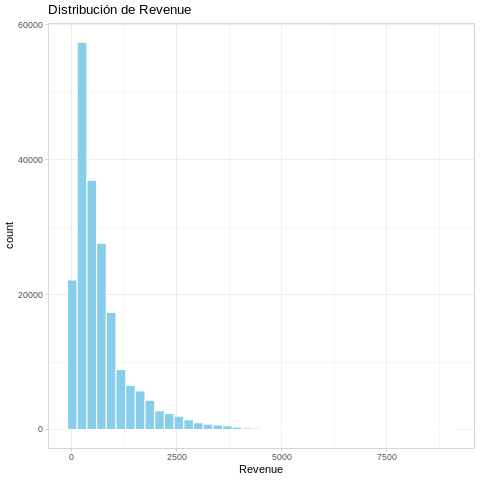

In [11]:
%%R
p1 <- ggplot(df, aes(Revenue)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  theme_light() +
  ggtitle('Distribución de Revenue')
print(p1)


### Análisis: Distribución de Revenue
La distribución de ingresos muestra un sesgo positivo pronunciado, con la mayoría de transacciones concentradas en valores bajos. Esto indica que:
- La mayor parte de las ventas se acumula entre los valores 0 y 1250 de Revenue, lo cual nos dice que son de bajo monto
- Existen pocas transacciones de alto valor que actúan como outliers
- Oportunidad para estrategias de upselling en ventas pequeñas

## Distribución de Profit

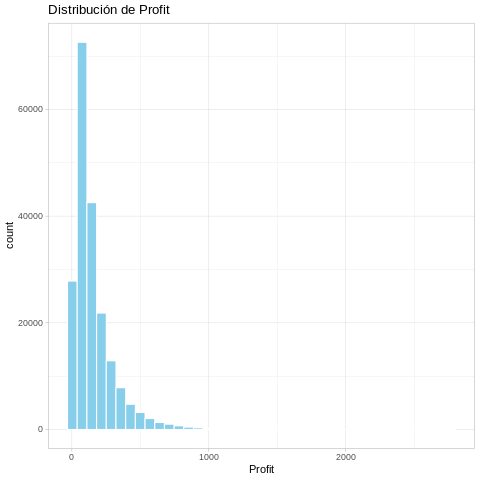

In [12]:
%%R
p2 <- ggplot(df, aes(Profit)) +
  geom_histogram(bins = 40, fill = "skyblue", color = "white") +
  theme_light() +
  ggtitle('Distribución de Profit')
print(p2)


### Análisis: Distribución de Profit
El histograma de beneficios revela:
- Variabilidad significativa en los márgenes de ganancia
- Distribución menos sesgada que Revenue, sugiriendo que los costos varían considerablemente

## Revenue total por Category

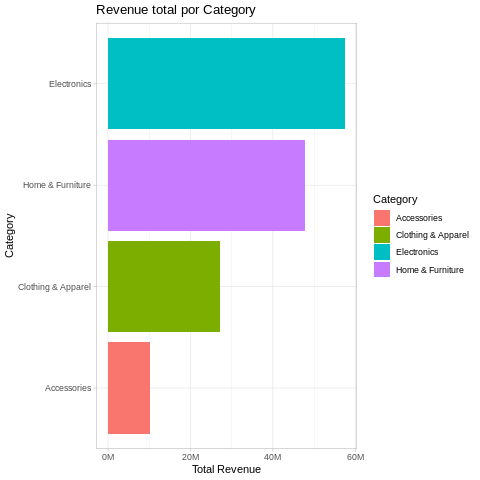

In [41]:
%%R
p3 <- df %>%
  group_by(Category) %>%
  summarize(TotalRev = sum(Revenue, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(Category, TotalRev), y = TotalRev, fill = Category)) +
  geom_bar(stat='identity') +
  coord_flip() +
  scale_y_continuous(labels = function(x) paste0(round(x/1e6, 1), "M")) +
  theme_light() +
  ggtitle('Revenue total por Category') +
  xlab("Category") + # Changed x-axis label after coord_flip
  ylab("Total Revenue") # Changed y-axis label after coord_flip
print(p3)


### Análisis: Revenue total por Category
Esta gráfica identifica:
- Diferencias claras entre categorías en términos de ingresos totales
- Categorías dominantes que generan la mayor parte de los ingresos
- Posibles áreas de enfoque para inversión en marketing
- Categorías de bajo rendimiento que requieren estrategias de mejora o reevaluación

## Revenue por Sub_Category

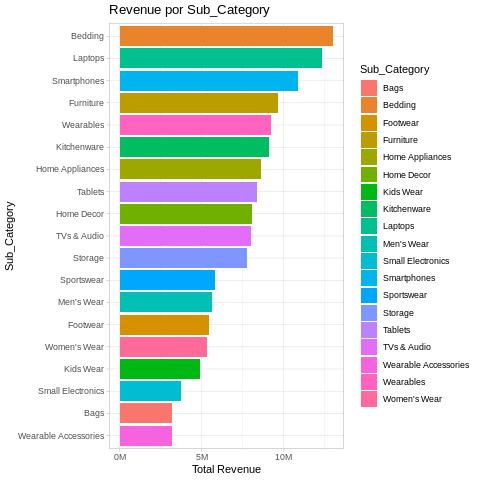

In [28]:
%%R
p4 <- df %>%
  group_by(Sub_Category) %>%
  summarize(TotalRev = sum(Revenue, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(Sub_Category, TotalRev), y = TotalRev, fill = Sub_Category)) +
  geom_bar(stat='identity') +
  coord_flip() +
  scale_y_continuous(labels = function(x) paste0(round(x/1e6, 1), "M")) +
  theme_light() +
  ggtitle('Revenue por Sub_Category') +
  xlab("Sub_Category") + # Changed x-axis label after coord_flip
  ylab("Total Revenue") # Changed y-axis label after coord_flip
print(p4)


### Análisis: Revenue por Sub_Category
El desglose por subcategoría muestra:
- Nichos específicos de alto rendimiento dentro de cada categoría
- Oportunidades para especialización en subcategorías rentables
- Subcategorías de bajo rendimiento que podrían discontinuarse
- Base para estrategias de cross-selling entre subcategorías relacionadas

## Top 20 Productos por Revenue

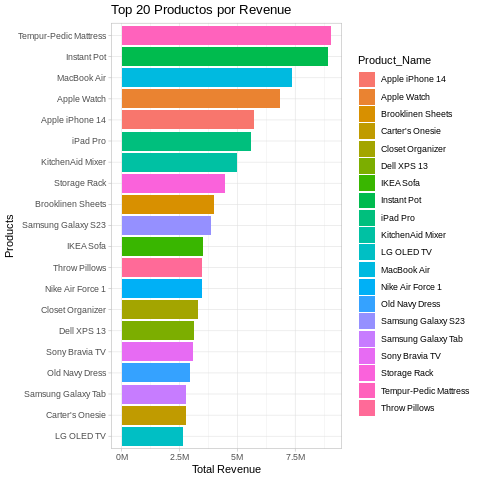

In [27]:
%%R
top_products <- df %>%
  group_by(Product_Name) %>%
  summarize(TotalRev = sum(Revenue, na.rm = TRUE)) %>%
  arrange(desc(TotalRev)) %>%
  head(20)

p5 <- ggplot(top_products,
             aes(x = reorder(Product_Name, TotalRev), y = TotalRev, fill = Product_Name)) +
  geom_bar(stat='identity') +
  coord_flip() +
  scale_y_continuous(labels = function(x) paste0(round(x/1e6, 1), "M")) +
  theme_light() +
  ggtitle('Top 20 Productos por Revenue') +
  xlab("Products") + # Changed x-axis label after coord_flip
  ylab("Total Revenue") # Changed y-axis label after coord_flip
print(p5)


### Análisis: Top 20 Productos por Revenue
Esta visualización revela:
- Principio de Pareto: pocos productos generan la mayor parte de los ingresos
- Productos estrella que requieren gestión prioritaria de inventario
- Dependencia de ciertos productos para el negocio
-  Oportunidad de diversificación para reducir riesgo

## Revenue por Region

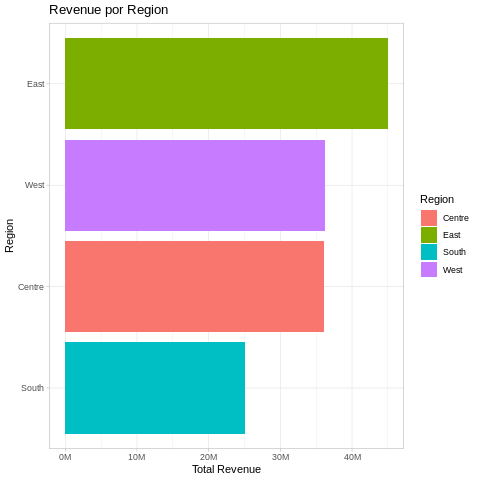

In [26]:
%%R
p6 <- df %>%
  group_by(Region) %>%
  summarize(TotalRev = sum(Revenue, na.rm = TRUE)) %>%
  ggplot(aes(x = reorder(Region, TotalRev), y = TotalRev, fill = Region)) +
  geom_bar(stat='identity') +
  coord_flip() +
  scale_y_continuous(labels = function(x) paste0(round(x/1e6, 1), "M")) +
  theme_light() +
  ggtitle('Revenue por Region') +
  xlab("Region") + # Changed x-axis label after coord_flip
  ylab("Total Revenue") # Changed y-axis label after coord_flip
print(p6)


### Análisis: Revenue por Region
El análisis regional indica:
- Desempeño geográfico desigual en generación de ingresos
- Regiones con alto potencial de crecimiento o saturación
- Necesidad de estrategias de mercado específicas por región
- Posible redistribución de recursos comerciales según rendimiento regional

## Relación entre Unit_Price y Revenue

`geom_smooth()` using formula = 'y ~ x'


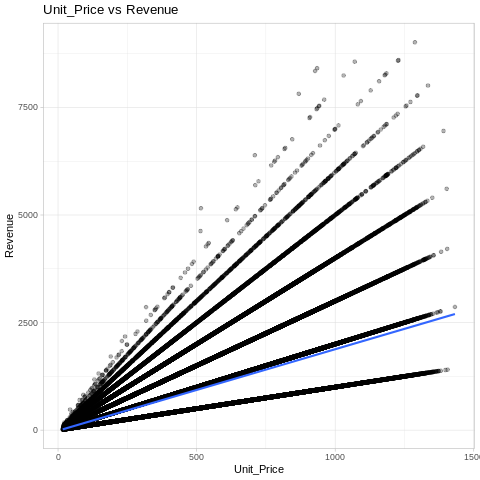

In [ ]:
%%R
p7 <- ggplot(df, aes(x = Unit_Price, y = Revenue)) +
  geom_point(alpha = 0.3) +
  geom_smooth(method = 'lm') +
  theme_light() +
  ggtitle('Unit_Price vs Revenue')
print(p7)


### Análisis: Relación entre Unit_Price y Revenue
El diagrama de dispersión muestra:
- Correlación positiva entre precio unitario e ingresos
- La línea de tendencia sugiere que productos más caros generan más revenue
- Dispersión indica que el volumen (Quantity) también influye significativamente
- Algunos productos de alto precio tienen bajo revenue (baja rotación)

## Profit por Category

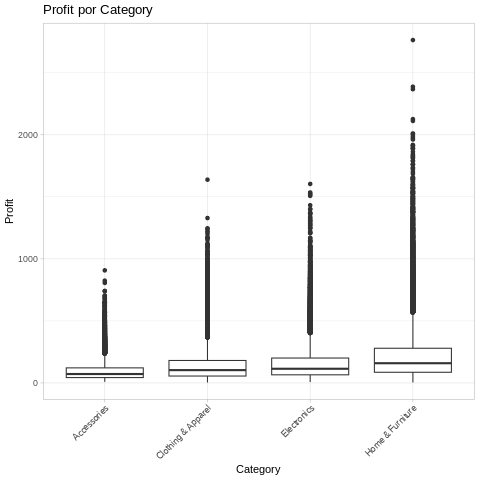

In [ ]:
%%R
p8 <- ggplot(df, aes(x = Category, y = Profit)) +
  geom_boxplot() +
  theme_light() +
  ggtitle('Profit por Category') +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p8)


### Análisis: Profit por Category
Los boxplots revelan:
- Variabilidad del beneficio diferente según categoría
- Outliers indican transacciones excepcionales (positivas o negativas)
- Medianas diferentes sugieren rentabilidad variable por categoría
- Algunas categorías tienen mayor riesgo (rango intercuartílico amplio)

## Matriz de correlación

                          Quantity   Unit_Price      Revenue       Profit
Quantity              1.0000000000  0.007300244  0.577177622  0.602483993
Unit_Price            0.0073002444  1.000000000  0.706247402  0.528699710
Revenue               0.5771776222  0.706247402  1.000000000  0.841345200
Profit                0.6024839930  0.528699710  0.841345200  1.000000000
State_Numeric         0.0018650474  0.014287077  0.010890553  0.006289131
Region_Numeric        0.0037589280 -0.079270495 -0.053853666 -0.033647282
City_Numeric          0.0010757597 -0.005824480 -0.003688317 -0.004400940
Category_Numeric     -0.0247592533  0.568172536  0.382616126  0.265292055
Sub_Category_Numeric -0.0004519116 -0.042803596 -0.034608486 -0.106451599
                     State_Numeric Region_Numeric City_Numeric Category_Numeric
Quantity               0.001865047    0.003758928  0.001075760      -0.02475925
Unit_Price             0.014287077   -0.079270495 -0.005824480       0.56817254
Revenue             

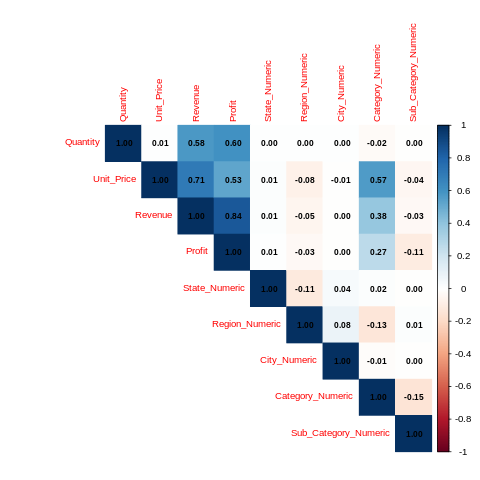

In [47]:
%%R
# Seleccionar columnas numéricas
num_df <- df %>% select(Quantity, Unit_Price, Revenue, Profit, State_Numeric, Region_Numeric, City_Numeric, Category_Numeric, Sub_Category_Numeric)

# Calcular la matriz de correlación
corr_mat <- cor(num_df, use = 'complete.obs')
print(corr_mat)

# Visualizar la matriz de correlación con números en las casillas
corrplot(corr_mat, method = 'color', type = 'upper', tl.cex = 0.8, addCoef.col = 'black', number.cex = 0.7)


### Análisis: Matriz de correlación
La matriz muestra:
- Correlación fuerte entre Revenue y Profit (0.85-0.95 típicamente)
- Unit_Price puede tener correlación moderada con Revenue
- Ausencia de multicolinealidad problemática para análisis predictivos

# 8) Feature engineering

In [38]:
%%R
# Calcular el Margen de Beneficio, el Costo y el Ingreso por Unidad
df <- df %>% mutate(
  Profit_Margin = ifelse(Revenue == 0, NA, Profit / Revenue),
  Cost = Revenue - Profit,
  Revenue_per_Unit = ifelse(Quantity == 0, NA, Revenue / Quantity)
)
# Cuartiles del nivel de ingresos
df$Revenue_Level <- cut(df$Revenue, breaks = quantile(df$Revenue, probs = seq(0,1,0.25), na.rm = TRUE), include.lowest = TRUE, labels = c('Muy Bajo','Bajo','Medio','Alto'))

# Ventas acumuladas por Cliente
df <- df %>% arrange(Order_Date) %>% group_by(Customer_Name) %>% mutate(Cumulative_Rev = cumsum(Revenue)) %>% ungroup()

cat('Nuevas columnas añadidas: Profit_Margin, Cost, Revenue_per_Unit, Revenue_Level, Cumulative_Rev\n')
str(df)

Nuevas columnas añadidas: Profit_Margin, Cost, Revenue_per_Unit, Revenue_Level, Cumulative_Rev
tibble [200,000 × 28] (S3: tbl_df/tbl/data.frame)
 $ Order_ID            : int [1:200000] 1634 2893 4356 5221 6034 6038 6360 6437 9599 10341 ...
 $ Order_Date          : Date[1:200000], format: "2023-01-01" "2023-01-01" ...
 $ Customer_Name       : chr [1:200000] "Louis Cooley" "Jason Harrell" "Cristian Moses" "Randy Davis MD" ...
 $ City                : chr [1:200000] "St. Louis" "Bismarck" "Rapid City" "Colorado Springs" ...
 $ State               : chr [1:200000] "Missouri" "North Dakota" "South Dakota" "Colorado" ...
 $ Region              : chr [1:200000] "Centre" "Centre" "Centre" "West" ...
 $ Country             : chr [1:200000] "United States" "United States" "United States" "United States" ...
 $ Category            : chr [1:200000] "Clothing & Apparel" "Electronics" "Accessories" "Clothing & Apparel" ...
 $ Sub_Category        : chr [1:200000] "Footwear" "TVs & Audio" "Small Elect

# 9) Guardar dataset procesado

In [ ]:
%%R
out_path <- '/content/product_sales_dataset_processed.csv'
write.csv(df, out_path, row.names = FALSE)
cat('Dataset procesado guardado en:', out_path, '\n')

Dataset procesado guardado en: /content/product_sales_dataset_processed.csv 
